In [1]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle

# Parameters
train_folder = '../Datasets/aqueduct, industrial_area, patio data sets/train/'
test_folder = '../Datasets/aqueduct, industrial_area, patio data sets/test/'
class_folders = ["aqueduct", "industrial_area", "patio"]
patch_size = 32
bins = 8
k = 32  # Number of clusters for K-means

# Patch extraction function
def extract_patches(image, patch_size=32):
    patches = []
    width, height = image.size
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            patch = image.crop((j, i, j + patch_size, i + patch_size))
            if patch.size == (patch_size, patch_size):
                patches.append(np.array(patch))
    return patches

# Color histogram extraction function
def color_histogram(patch, bins=8):
    hist_r = np.histogram(patch[:, :, 0], bins=bins, range=(0, 256))[0]
    hist_g = np.histogram(patch[:, :, 1], bins=bins, range=(0, 256))[0]
    hist_b = np.histogram(patch[:, :, 2], bins=bins, range=(0, 256))[0]
    return np.concatenate([hist_r, hist_g, hist_b])

# K-means implementation from scratch
def initialize_centroids(features, k):
    indices = np.random.choice(len(features), k, replace=False)
    return features[indices]

def assign_clusters(features, centroids):
    distances = np.linalg.norm(features[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def update_centroids(features, labels, k):
    new_centroids = np.zeros((k, features.shape[1]))
    for i in range(k):
        points_in_cluster = features[labels == i]
        if len(points_in_cluster) > 0:
            new_centroids[i] = np.mean(points_in_cluster, axis=0)
    return new_centroids

def kmeans(features, k, max_iter=100, tol=1e-4):
    centroids = initialize_centroids(features, k)
    for _ in range(max_iter):
        labels = assign_clusters(features, centroids)
        new_centroids = update_centroids(features, labels, k)
        if np.linalg.norm(new_centroids - centroids) < tol:
            break
        centroids = new_centroids
    return centroids, labels

# BoVW representation for an image
def bovw_representation(image_patches, centroids):
    features = [color_histogram(patch) for patch in image_patches]
    features = np.array(features)
    labels = assign_clusters(features, centroids)
    bovw_hist = np.bincount(labels, minlength=len(centroids))
    return bovw_hist / len(features)

# Save data function
def save_data(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

# Load data function
def load_data(filename):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            return pickle.load(f)
    return None

# Process images and save BoVW representations for each class separately
def process_images(folder, class_folders, centroids, save_folder, prefix):
    for i, class_name in enumerate(class_folders, 1):
        class_folder = os.path.join(folder, class_name)
        class_data = []
        
        for img_name in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_name)
            img = Image.open(img_path)
            patches = extract_patches(img, patch_size)
            bovw_vector = bovw_representation(patches, centroids)
            class_data.append((img_name, bovw_vector, class_name))
        
        # Save each class data in a separate file for each image
        for j, data in enumerate(class_data, 1):
            img_name, bovw_vector, class_name = data
            save_data(bovw_vector, os.path.join(save_folder, f'{prefix}_data{i}_{j}.pkl'))

# Main workflow
def main():
    # Check if BoVW data exists; if not, process it
    if not os.path.exists('train_data1_1.pkl'):
        # Collect all patches from training images to fit K-means
        all_train_features = []
        for class_name in class_folders:
            class_folder = os.path.join(train_folder, class_name)
            for img_name in os.listdir(class_folder):
                img_path = os.path.join(class_folder, img_name)
                img = Image.open(img_path)
                patches = extract_patches(img, patch_size)
                for patch in patches:
                    all_train_features.append(color_histogram(patch))

        all_train_features = np.array(all_train_features)
        print("Total training patches:", len(all_train_features))

        # Apply K-means clustering
        centroids, _ = kmeans(all_train_features, k)
        print("K-means clustering completed.")

        # Process train and test datasets and save each class separately
        process_images(train_folder, class_folders, centroids, os.getcwd(), prefix='train')
        process_images(test_folder, class_folders, centroids, os.getcwd(), prefix='test')
        
        print("BoVW representations saved for each class.")
    else:
        print("BoVW data already exists.")

if __name__ == "__main__":
    main()


Total training patches: 204224
K-means clustering completed.
BoVW representations saved for each class.


In [2]:
import pickle
import os

# Initialize empty lists to store train and test data for each class
train_data1, train_data2, train_data3 = [], [], []
test_data1, test_data2, test_data3 = [], [], []

# Loop through all pickle files in the current directory
for filename in os.listdir('.'):
    if filename.endswith('.pkl'):
        # Load the pickle file
        with open(filename, 'rb') as file:
            data = pickle.load(file)
        
        # Determine which class the file belongs to based on the filename
        if 'train_data1_' in filename:
            train_data1.append(data)
        elif 'train_data2_' in filename:
            train_data2.append(data)
        elif 'train_data3_' in filename:
            train_data3.append(data)
        elif 'test_data1_' in filename:
            test_data1.append(data)
        elif 'test_data2_' in filename:
            test_data2.append(data)
        elif 'test_data3_' in filename:
            test_data3.append(data)

print("Data concatenation and completed.")
print(len(train_data1))
print(len(train_data2))
print(len(train_data3))
print(len(test_data1))
print(len(test_data2))
print(len(test_data3))

Data concatenation and completed.
50
50
50
50
50
50


In [3]:
train_labels1 = np.ones(len(train_data1))  # All samples in train_data1 are class 1
train_labels2 = np.ones(len(train_data2)) * 2  # All samples in train_data2 are class 2
train_labels3 = np.ones(len(train_data3)) * 3  # All samples in train_data3 are class 3

test_labels1 = np.ones(len(test_data1))  # All samples in test_data1 are class 1
test_labels2 = np.ones(len(test_data2)) * 2  # All samples in test_data2 are class 2
test_labels3 = np.ones(len(test_data3)) * 3  # All samples in test_data3 are class 3

# Concatenating the data
train_data = np.concatenate([train_data1, train_data2, train_data3], axis=0)
test_data = np.concatenate([test_data1, test_data2, test_data3], axis=0)

# Concatenating the labels
train_labels = np.concatenate([train_labels1, train_labels2, train_labels3], axis=0)
test_labels = np.concatenate([test_labels1, test_labels2, test_labels3], axis=0)
print(len(train_data))
print(len(train_labels))
print(len(test_data))
print(len(test_labels))

150
150
150
150



Performance for Class 1 vs Class 2 (K=1):
Classification Metrics:
Accuracy: 0.64
Precision per class: {1: np.float64(0.6129032258064516), 2: np.float64(0.6842105263157895)}
Recall per class: {1: np.float64(0.76), 2: np.float64(0.52)}
F1-Score per class: {1: np.float64(0.6785714285714286), 2: np.float64(0.5909090909090909)}
Mean Precision: 0.65
Mean Recall: 0.64
Mean F1-Score: 0.63


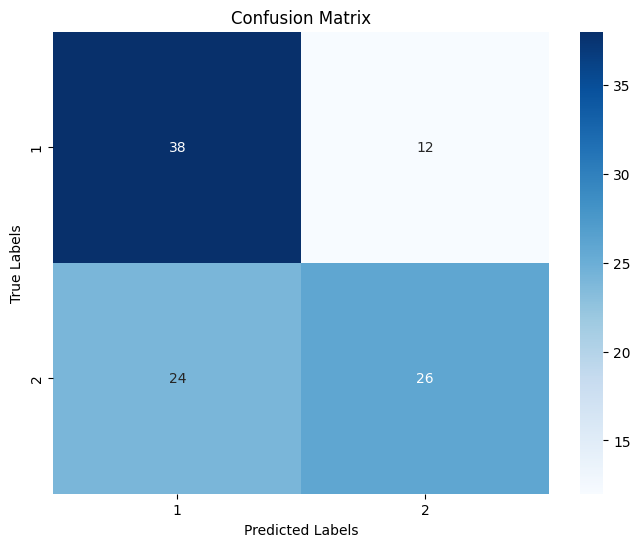


Performance for Class 2 vs Class 3 (K=1):
Classification Metrics:
Accuracy: 0.67
Precision per class: {2: np.float64(0.7575757575757576), 3: np.float64(0.6268656716417911)}
Recall per class: {2: np.float64(0.5), 3: np.float64(0.84)}
F1-Score per class: {2: np.float64(0.6024096385542169), 3: np.float64(0.717948717948718)}
Mean Precision: 0.69
Mean Recall: 0.67
Mean F1-Score: 0.66


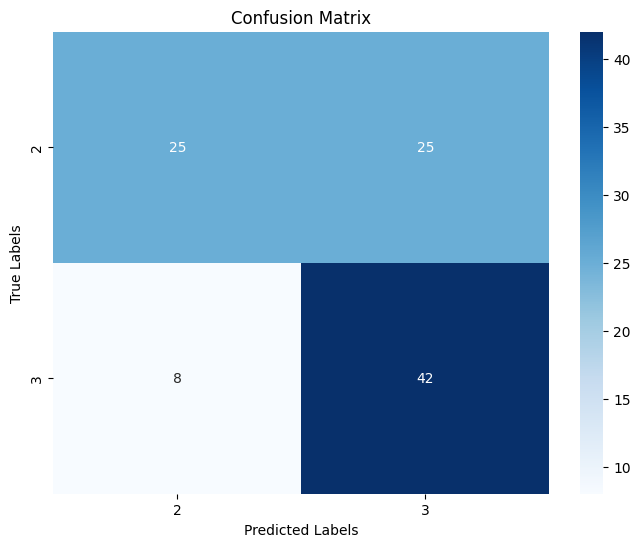


Performance for Class 3 vs Class 1 (K=1):
Classification Metrics:
Accuracy: 0.66
Precision per class: {3: np.float64(0.6333333333333333), 1: np.float64(0.7)}
Recall per class: {3: np.float64(0.76), 1: np.float64(0.56)}
F1-Score per class: {3: np.float64(0.6909090909090909), 1: np.float64(0.6222222222222222)}
Mean Precision: 0.67
Mean Recall: 0.66
Mean F1-Score: 0.66


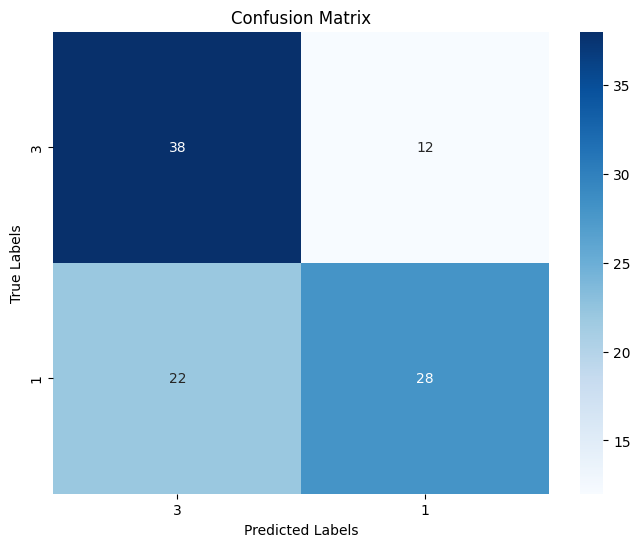


Performance for All Classes (K=1):
Classification Metrics:
Accuracy: 0.50
Precision per class: {np.float64(1.0): np.float64(0.44680851063829785), np.float64(2.0): np.float64(0.5588235294117647), np.float64(3.0): np.float64(0.5072463768115942)}
Recall per class: {np.float64(1.0): np.float64(0.42), np.float64(2.0): np.float64(0.38), np.float64(3.0): np.float64(0.7)}
F1-Score per class: {np.float64(1.0): np.float64(0.4329896907216495), np.float64(2.0): np.float64(0.4523809523809524), np.float64(3.0): np.float64(0.5882352941176471)}
Mean Precision: 0.50
Mean Recall: 0.50
Mean F1-Score: 0.49


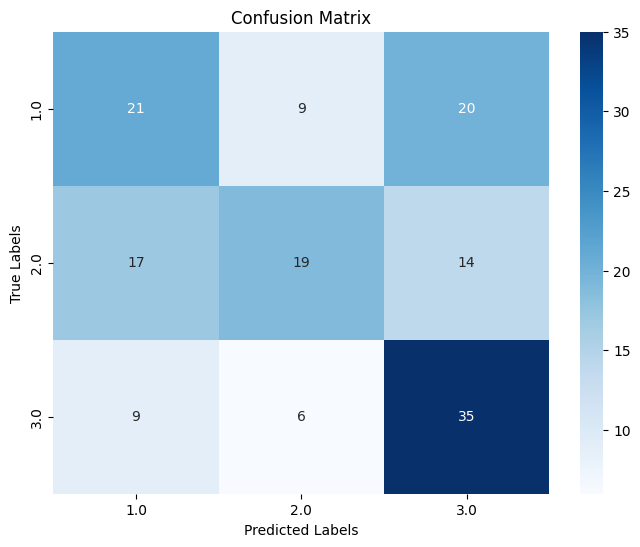


Performance for Class 1 vs Class 2 (K=2):
Classification Metrics:
Accuracy: 0.64
Precision per class: {1: np.float64(0.6166666666666667), 2: np.float64(0.675)}
Recall per class: {1: np.float64(0.74), 2: np.float64(0.54)}
F1-Score per class: {1: np.float64(0.6727272727272727), 2: np.float64(0.6)}
Mean Precision: 0.65
Mean Recall: 0.64
Mean F1-Score: 0.64


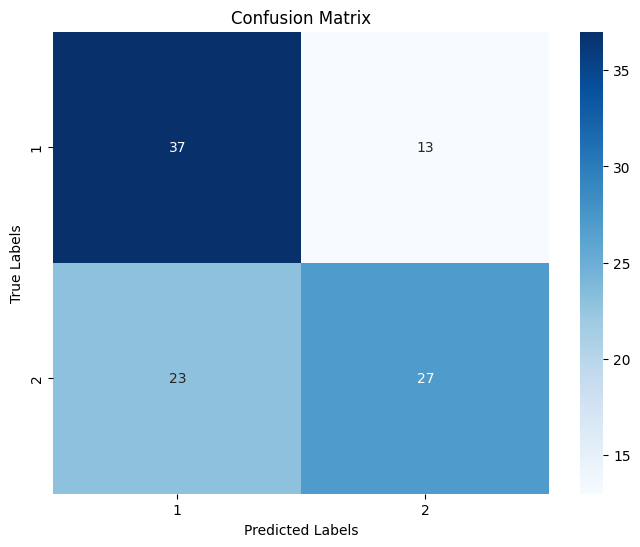


Performance for Class 2 vs Class 3 (K=2):
Classification Metrics:
Accuracy: 0.67
Precision per class: {2: np.float64(0.8148148148148148), 3: np.float64(0.6164383561643836)}
Recall per class: {2: np.float64(0.44), 3: np.float64(0.9)}
F1-Score per class: {2: np.float64(0.5714285714285714), 3: np.float64(0.7317073170731707)}
Mean Precision: 0.72
Mean Recall: 0.67
Mean F1-Score: 0.65


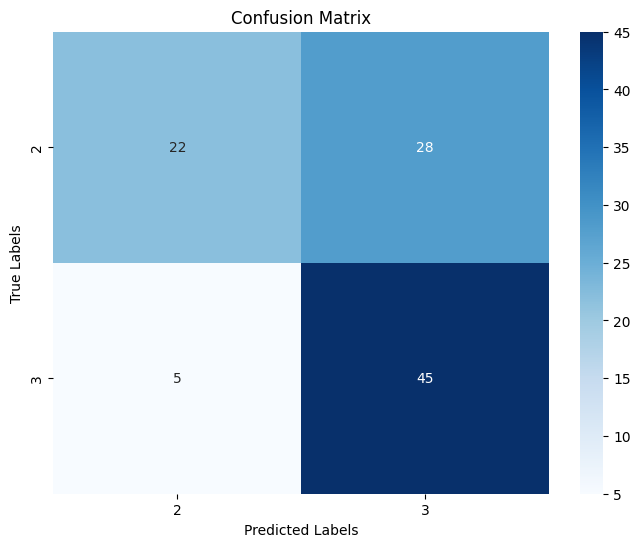


Performance for Class 3 vs Class 1 (K=2):
Classification Metrics:
Accuracy: 0.74
Precision per class: {3: np.float64(0.6666666666666666), 1: np.float64(0.9285714285714286)}
Recall per class: {3: np.float64(0.96), 1: np.float64(0.52)}
F1-Score per class: {3: np.float64(0.7868852459016393), 1: np.float64(0.6666666666666666)}
Mean Precision: 0.80
Mean Recall: 0.74
Mean F1-Score: 0.73


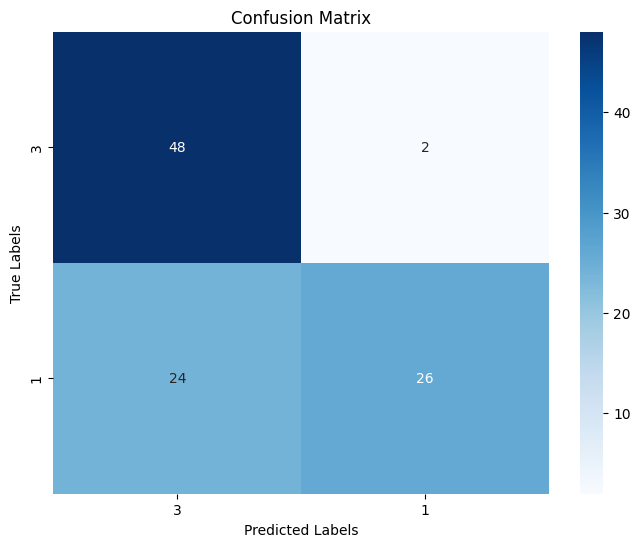


Performance for All Classes (K=2):
Classification Metrics:
Accuracy: 0.56
Precision per class: {np.float64(1.0): np.float64(0.5882352941176471), np.float64(2.0): np.float64(0.6129032258064516), np.float64(3.0): np.float64(0.5294117647058824)}
Recall per class: {np.float64(1.0): np.float64(0.4), np.float64(2.0): np.float64(0.38), np.float64(3.0): np.float64(0.9)}
F1-Score per class: {np.float64(1.0): np.float64(0.47619047619047616), np.float64(2.0): np.float64(0.4691358024691358), np.float64(3.0): np.float64(0.6666666666666666)}
Mean Precision: 0.58
Mean Recall: 0.56
Mean F1-Score: 0.54


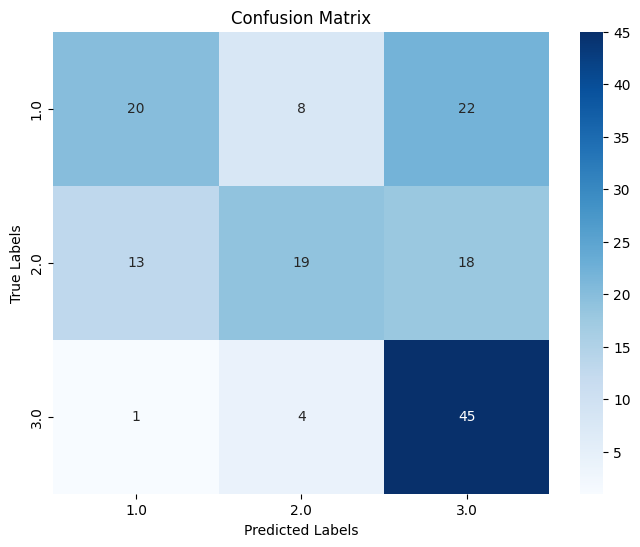


Performance for Class 1 vs Class 2 (K=3):
Classification Metrics:
Accuracy: 0.67
Precision per class: {1: np.float64(0.639344262295082), 2: np.float64(0.717948717948718)}
Recall per class: {1: np.float64(0.78), 2: np.float64(0.56)}
F1-Score per class: {1: np.float64(0.7027027027027027), 2: np.float64(0.6292134831460674)}
Mean Precision: 0.68
Mean Recall: 0.67
Mean F1-Score: 0.67


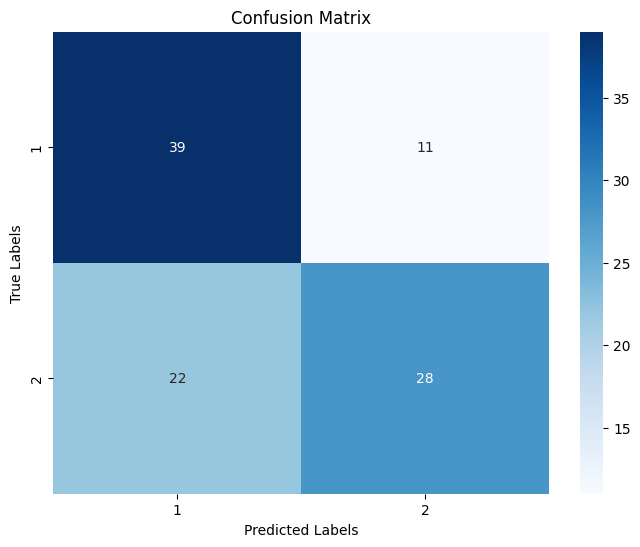


Performance for Class 2 vs Class 3 (K=3):
Classification Metrics:
Accuracy: 0.68
Precision per class: {2: np.float64(0.9090909090909091), 3: np.float64(0.6153846153846154)}
Recall per class: {2: np.float64(0.4), 3: np.float64(0.96)}
F1-Score per class: {2: np.float64(0.5555555555555556), 3: np.float64(0.75)}
Mean Precision: 0.76
Mean Recall: 0.68
Mean F1-Score: 0.65


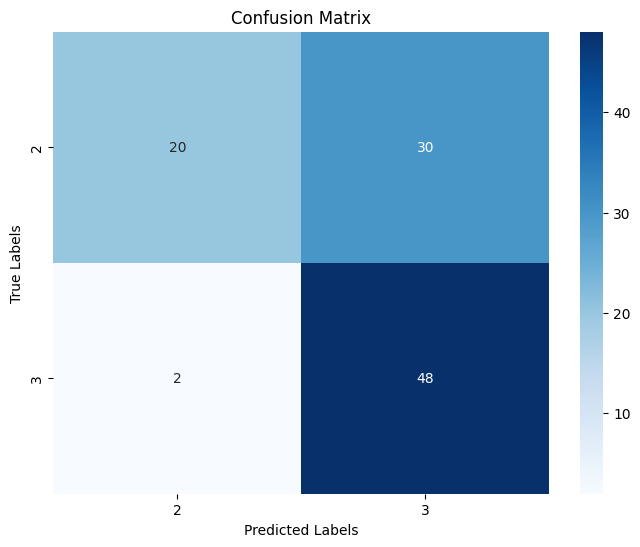


Performance for Class 3 vs Class 1 (K=3):
Classification Metrics:
Accuracy: 0.73
Precision per class: {3: np.float64(0.6533333333333333), 1: np.float64(0.96)}
Recall per class: {3: np.float64(0.98), 1: np.float64(0.48)}
F1-Score per class: {3: np.float64(0.784), 1: np.float64(0.64)}
Mean Precision: 0.81
Mean Recall: 0.73
Mean F1-Score: 0.71


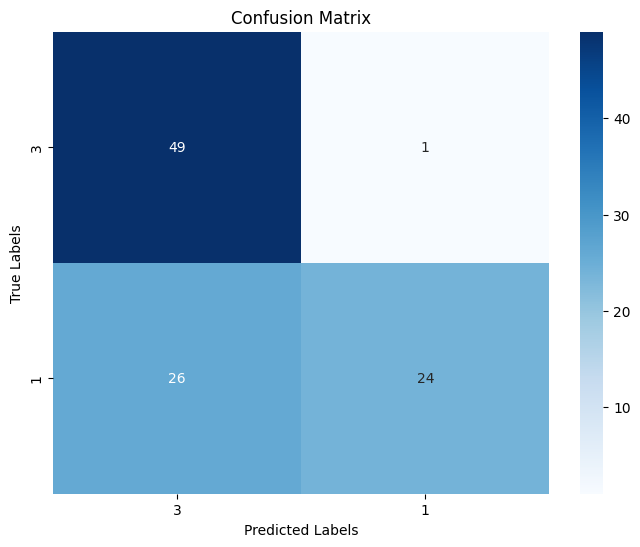


Performance for All Classes (K=3):
Classification Metrics:
Accuracy: 0.59
Precision per class: {np.float64(1.0): np.float64(0.7333333333333333), np.float64(2.0): np.float64(0.6923076923076923), np.float64(3.0): np.float64(0.5106382978723404)}
Recall per class: {np.float64(1.0): np.float64(0.44), np.float64(2.0): np.float64(0.36), np.float64(3.0): np.float64(0.96)}
F1-Score per class: {np.float64(1.0): np.float64(0.55), np.float64(2.0): np.float64(0.47368421052631576), np.float64(3.0): np.float64(0.6666666666666666)}
Mean Precision: 0.65
Mean Recall: 0.59
Mean F1-Score: 0.56


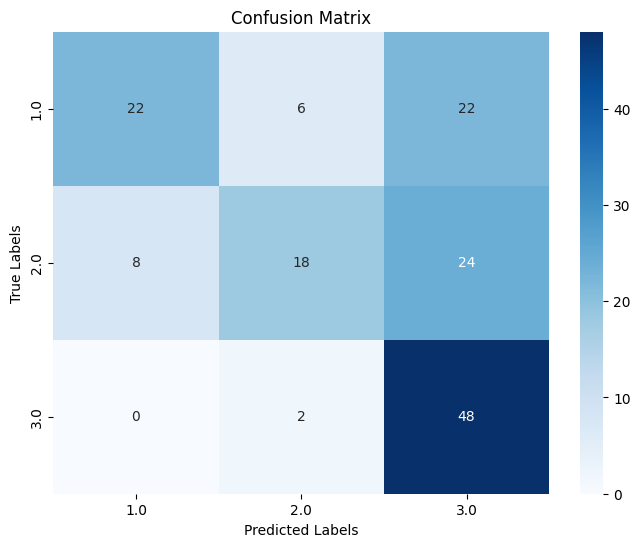


Performance for Class 1 vs Class 2 (K=5):
Classification Metrics:
Accuracy: 0.69
Precision per class: {1: np.float64(0.6507936507936508), 2: np.float64(0.7567567567567568)}
Recall per class: {1: np.float64(0.82), 2: np.float64(0.56)}
F1-Score per class: {1: np.float64(0.7256637168141593), 2: np.float64(0.6436781609195402)}
Mean Precision: 0.70
Mean Recall: 0.69
Mean F1-Score: 0.68


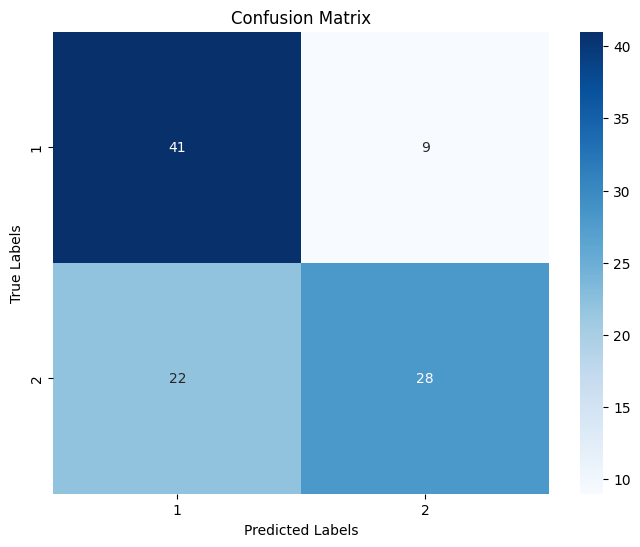


Performance for Class 2 vs Class 3 (K=5):
Classification Metrics:
Accuracy: 0.71
Precision per class: {2: np.float64(0.92), 3: np.float64(0.64)}
Recall per class: {2: np.float64(0.46), 3: np.float64(0.96)}
F1-Score per class: {2: np.float64(0.6133333333333333), 3: np.float64(0.768)}
Mean Precision: 0.78
Mean Recall: 0.71
Mean F1-Score: 0.69


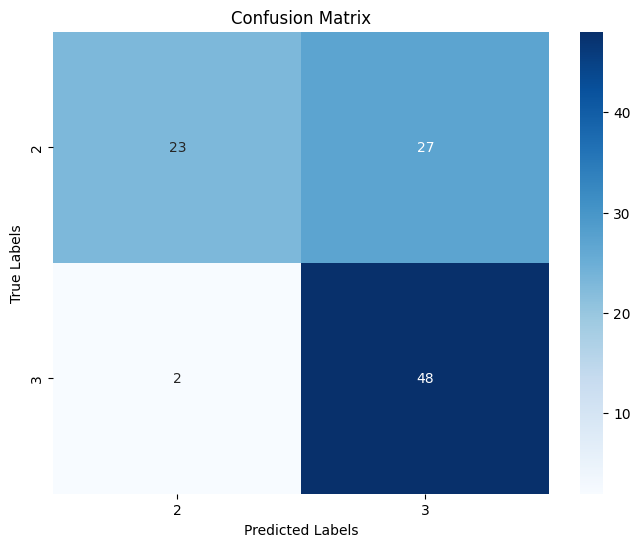


Performance for Class 3 vs Class 1 (K=5):
Classification Metrics:
Accuracy: 0.64
Precision per class: {3: np.float64(0.5853658536585366), 1: np.float64(0.8888888888888888)}
Recall per class: {3: np.float64(0.96), 1: np.float64(0.32)}
F1-Score per class: {3: np.float64(0.7272727272727273), 1: np.float64(0.47058823529411764)}
Mean Precision: 0.74
Mean Recall: 0.64
Mean F1-Score: 0.60


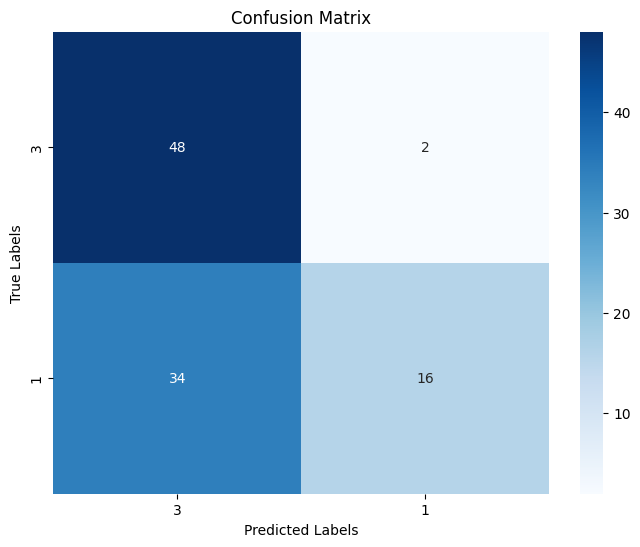


Performance for All Classes (K=5):
Classification Metrics:
Accuracy: 0.54
Precision per class: {np.float64(1.0): np.float64(0.64), np.float64(2.0): np.float64(0.8181818181818182), np.float64(3.0): np.float64(0.4563106796116505)}
Recall per class: {np.float64(1.0): np.float64(0.32), np.float64(2.0): np.float64(0.36), np.float64(3.0): np.float64(0.94)}
F1-Score per class: {np.float64(1.0): np.float64(0.4266666666666667), np.float64(2.0): np.float64(0.5), np.float64(3.0): np.float64(0.6143790849673203)}
Mean Precision: 0.64
Mean Recall: 0.54
Mean F1-Score: 0.51


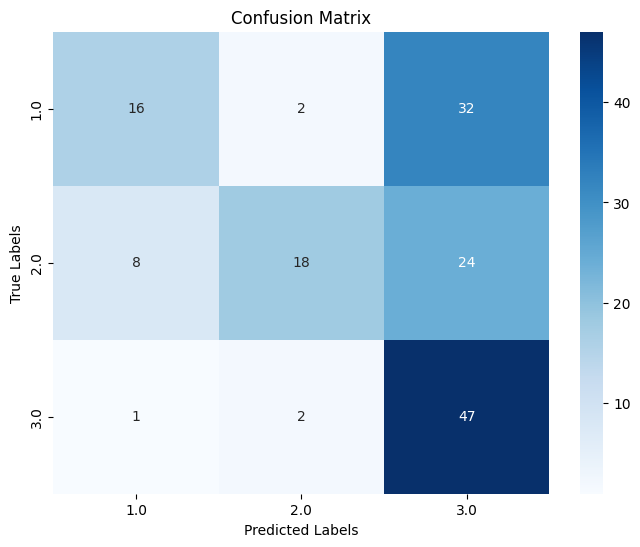


Performance for Class 1 vs Class 2 (K=10):
Classification Metrics:
Accuracy: 0.65
Precision per class: {1: np.float64(0.6), 2: np.float64(0.8)}
Recall per class: {1: np.float64(0.9), 2: np.float64(0.4)}
F1-Score per class: {1: np.float64(0.72), 2: np.float64(0.5333333333333333)}
Mean Precision: 0.70
Mean Recall: 0.65
Mean F1-Score: 0.63


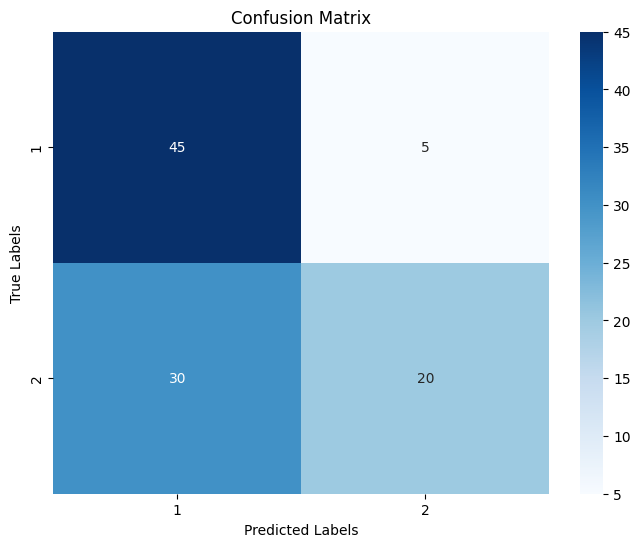


Performance for Class 2 vs Class 3 (K=10):
Classification Metrics:
Accuracy: 0.58
Precision per class: {2: np.float64(0.9), 3: np.float64(0.5444444444444444)}
Recall per class: {2: np.float64(0.18), 3: np.float64(0.98)}
F1-Score per class: {2: np.float64(0.3), 3: np.float64(0.7)}
Mean Precision: 0.72
Mean Recall: 0.58
Mean F1-Score: 0.50


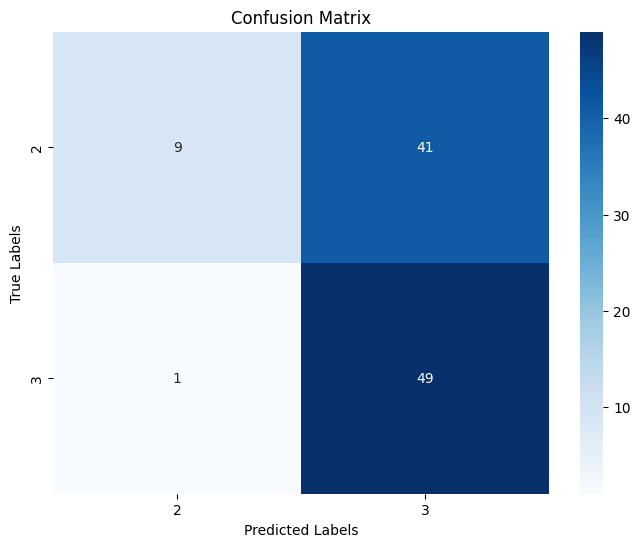


Performance for Class 3 vs Class 1 (K=10):
Classification Metrics:
Accuracy: 0.61
Precision per class: {3: np.float64(0.5662650602409639), 1: np.float64(0.8235294117647058)}
Recall per class: {3: np.float64(0.94), 1: np.float64(0.28)}
F1-Score per class: {3: np.float64(0.706766917293233), 1: np.float64(0.417910447761194)}
Mean Precision: 0.69
Mean Recall: 0.61
Mean F1-Score: 0.56


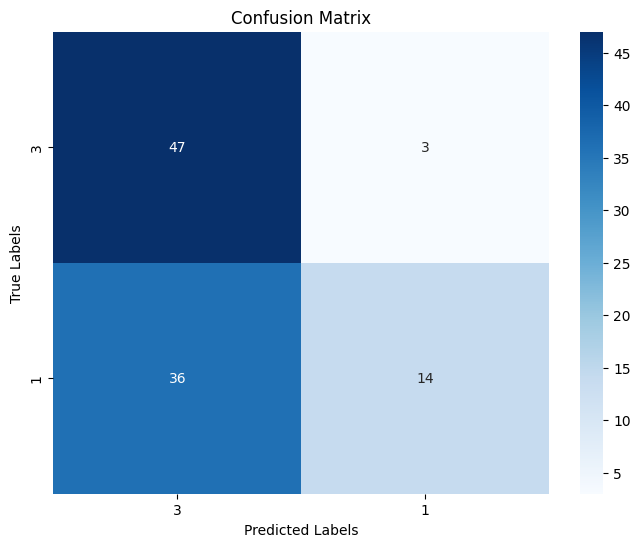


Performance for All Classes (K=10):
Classification Metrics:
Accuracy: 0.47
Precision per class: {np.float64(1.0): np.float64(0.56), np.float64(2.0): np.float64(0.8181818181818182), np.float64(3.0): np.float64(0.41228070175438597)}
Recall per class: {np.float64(1.0): np.float64(0.28), np.float64(2.0): np.float64(0.18), np.float64(3.0): np.float64(0.94)}
F1-Score per class: {np.float64(1.0): np.float64(0.37333333333333335), np.float64(2.0): np.float64(0.29508196721311475), np.float64(3.0): np.float64(0.573170731707317)}
Mean Precision: 0.60
Mean Recall: 0.47
Mean F1-Score: 0.41


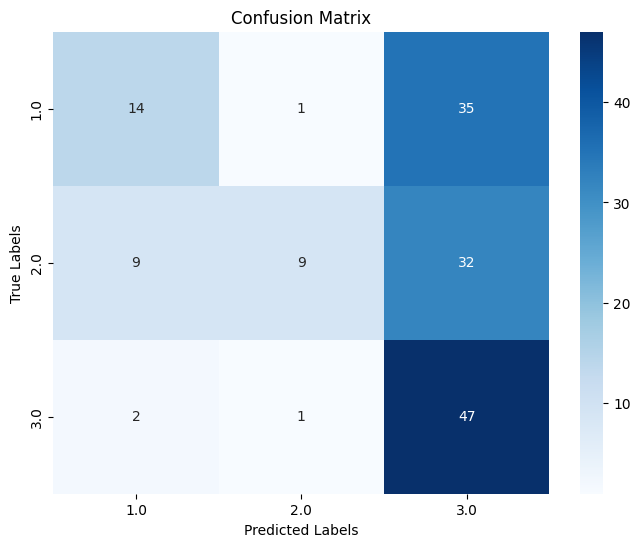

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import seaborn as sns

def knn_density_estimation(train_data, train_labels, test_data, K):
    densities = []
    labels = np.unique(train_labels)
    knn = NearestNeighbors(n_neighbors=K)
    knn.fit(train_data)
    for x in test_data:
        class_density = {}
        for label in labels:
            X_class = train_data[train_labels == label]
            current_K = min(K, len(X_class))
            if current_K == 0:
                density = 0
            else:
                knn_class = NearestNeighbors(n_neighbors=current_K)
                knn_class.fit(X_class)
                distances, _ = knn_class.kneighbors([x])
                volume = np.prod(distances.max(axis=1)) if distances.size > 0 else 1e-10
                density = current_K / (len(X_class) * volume)
            class_density[label] = density
        densities.append(class_density)
    return densities

def bayes_classifier_knn(train_data, train_labels, test_data, K):
    class_counts = Counter(train_labels)
    total_count = len(train_labels)
    priors = {label: count / total_count for label, count in class_counts.items()}
    densities = knn_density_estimation(train_data, train_labels, test_data, K)
    predictions = []
    for density in densities:
        posteriors = {label: priors[label] * density.get(label, 0) for label in priors}
        if all(value == 0 for value in posteriors.values()):
            predicted_class = np.random.choice(list(priors.keys()))
        else:
            predicted_class = max(posteriors, key=posteriors.get)
        predictions.append(predicted_class)
    return predictions

def plot_decision_regions(train_data, train_labels, test_data, test_labels, predictions, K, classes, title):
    h = 0.1
    x_min, x_max = train_data[:, 0].min() - 1, train_data[:, 0].max() + 1
    y_min, y_max = train_data[:, 1].min() - 1, train_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    
    grid_predictions = bayes_classifier_knn(train_data, train_labels, grid_points, K)
    grid_predictions = np.array(grid_predictions).reshape(xx.shape)
    
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, grid_predictions, alpha=0.8, cmap=plt.cm.Paired)
    
    for label, marker, color in zip(classes, ['o', 's', '^'], ['blue', 'red', 'green']):
        class_train = train_data[train_labels == label]
        class_test = test_data[test_labels == label]
        plt.scatter(class_train[:, 0], class_train[:, 1], c=color, label=f"Train Class {label}", edgecolor='k', marker=marker)
        plt.scatter(class_test[:, 0], class_test[:, 1], c=color, label=f"Test Class {label}", edgecolor='k', facecolors='none', marker=marker)
    
    plt.title(f"{title} (K={K})")
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()
def evaluate_performance(test_labels, predictions, classes):
    accuracy = accuracy_score(test_labels, predictions)
    precision = precision_score(test_labels, predictions, average=None, labels=classes)
    recall = recall_score(test_labels, predictions, average=None, labels=classes)
    f1 = f1_score(test_labels, predictions, average=None, labels=classes)
    
    mean_precision = precision.mean()
    mean_recall = recall.mean()
    mean_f1 = f1.mean()
    
    print("Classification Metrics:")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision per class: {dict(zip(classes, precision))}")
    print(f"Recall per class: {dict(zip(classes, recall))}")
    print(f"F1-Score per class: {dict(zip(classes, f1))}")
    print(f"Mean Precision: {mean_precision:.2f}")
    print(f"Mean Recall: {mean_recall:.2f}")
    print(f"Mean F1-Score: {mean_f1:.2f}")
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(test_labels, predictions, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


k = [1, 2, 3, 5, 10]
class_pairs = [(1, 2), (2, 3), (3, 1)]

for K in k:
    for pair in class_pairs:
        mask_train = np.isin(train_labels, pair)
        mask_test = np.isin(test_labels, pair)
        
        train_data_pair = train_data[mask_train]
        train_labels_pair = train_labels[mask_train]
        test_data_pair = test_data[mask_test]
        test_labels_pair = test_labels[mask_test]
        
        predictions_pair = bayes_classifier_knn(train_data_pair, train_labels_pair, test_data_pair, K)
       
        
        print(f"\nPerformance for Class {pair[0]} vs Class {pair[1]} (K={K}):")
        evaluate_performance(test_labels_pair, predictions_pair, pair)
    
    predictions_all = bayes_classifier_knn(train_data, train_labels, test_data, K)
    
    
    print(f"\nPerformance for All Classes (K={K}):")
    evaluate_performance(test_labels, predictions_all, np.unique(train_labels))
   